In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train_size = 0.8
val_size = 0.2

In [20]:
def normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    
    return torch.round(tensor)


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:normalization(tensor, 0, 1))
])

def add_noise(img_tensor, std=0.5, mean=0):
    return (img_tensor + torch.rand(img_tensor.size(), device=device) * std + mean)

In [4]:
train_data  = torchvision.datasets.MNIST("./data", train=True, transform=img_transform, download=False)
test_data = torchvision.datasets.MNIST("./data", train=False, transform=img_transform, download=False)

data_size = len(train_data)

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
generator = torch.Generator().manual_seed(42)
train_set, val_set = torch.utils.data.random_split(train_data, [int(train_size*data_size), int(val_size*data_size)], generator=generator)

In [7]:
len(train_set), len(val_set)

(48000, 12000)

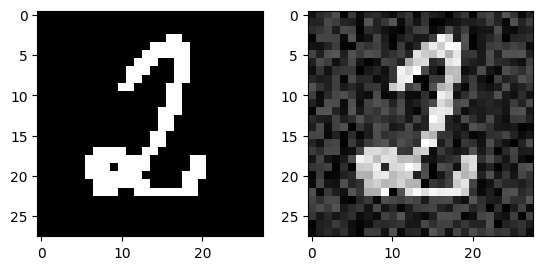

In [8]:
fig, ax = plt.subplots(1, 2)
j = 260
x, _ = train_set[j]
ax[0].imshow(x.numpy()[0], cmap='gray')
ax[1].imshow(add_noise(x).numpy()[0], cmap='gray')

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim:int = 784, latent_dim:int = 128):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(input_dim, latent_dim),
                                     nn.GELU())
        
        self.decoder = nn.Sequential(nn.Linear(latent_dim, input_dim),
                                     nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)

        return self.decoder(x)

In [10]:
model = AutoEncoder().to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True, pin_memory=True)

In [21]:
epochs = 1
for epoch in range(epochs):
    for input_img, _ in train_loader:
        input_img = input_img.to(device) #TODO: find a way to do this more efficient
        out = model(add_noise(input_img))

        loss = criterion(out, input_img)

ValueError: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 784])) is deprecated. Please ensure they have the same size.